# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [72]:
import pandas as pd

In [73]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

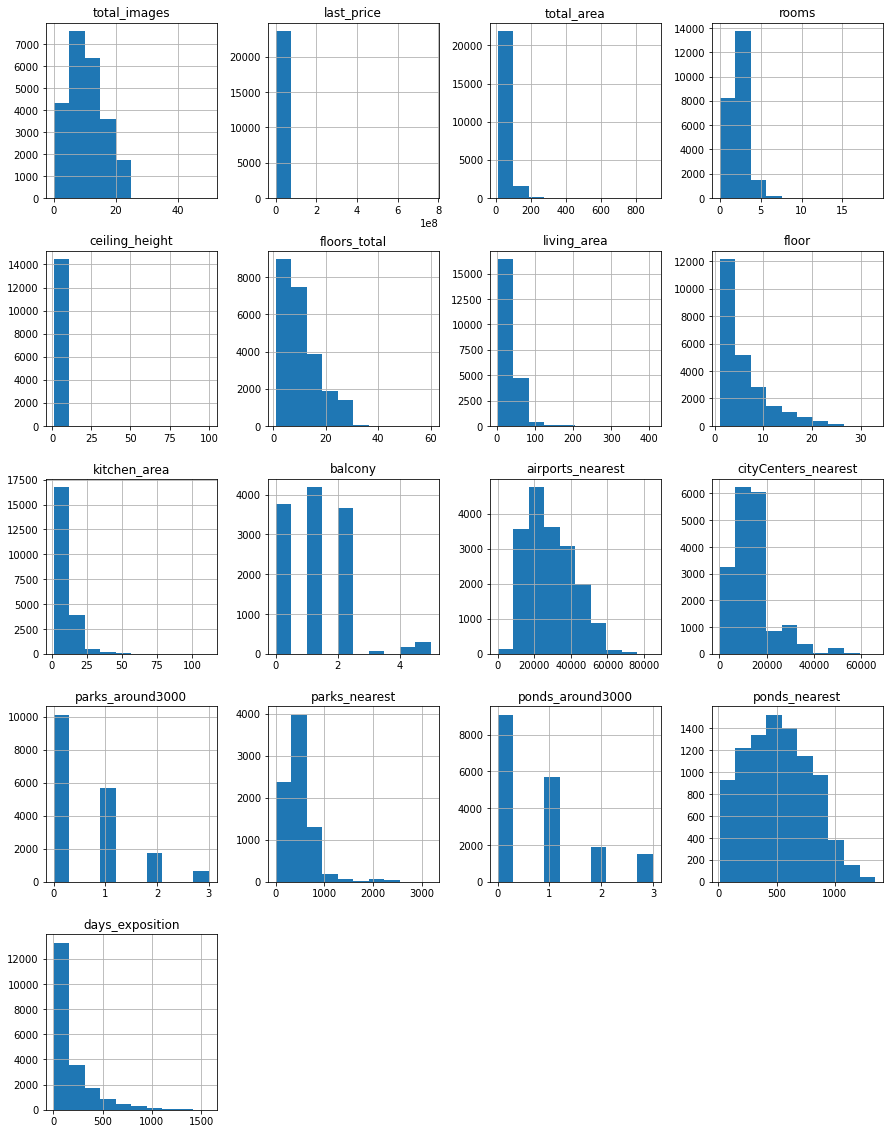

In [74]:
df.hist(figsize=(15, 20));

Промежуточные выводы: имеем датафрейм с 23698 строками и 22 колонками, во множестве столбцов имеем пропущенные значения, которые нужно постараться заполнить.

### Предобработка данных

#### Найдём пропущенные значения в столбцах, попробуем их заполнить

In [75]:
#Определим пропущенные значения.
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [76]:
# код ревьюера
df.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
total_images,0.00%
open_plan,0.00%
floor,0.00%
rooms,0.00%
studio,0.00%
total_area,0.00%
last_price,0.00%
first_day_exposition,0.00%
locality_name,0.21%
floors_total,0.36%


Пропуски обноружены в столбцах: ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.

В столбце floors_total не должно остаться пропусков, так как у каждого дома есть число этажей, заполним эти столбцы медианным значением.

In [77]:
#df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace=True)
df['floors_total'].fillna(df['floors_total'].median(), inplace=True)
#df['living_area'].fillna(df['living_area'].median(), inplace=True)
#df['kitchen_area'].fillna(df['kitchen_area'].median(), inplace=True)

In [78]:
#Посчитаем среднюю долю площади кухни от общей площади
kitchen_percentage = df.loc[~df['kitchen_area'].isna(), 'kitchen_area'] / df.loc[~df['kitchen_area'].isna(), 'total_area']
kitchen_percentage = round(kitchen_percentage.median(), 1)
print(kitchen_percentage)

0.2


In [79]:
#Заполним пропуски в площади кухни
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df.loc[df['kitchen_area'].isna(), 'total_area'] * kitchen_percentage

In [80]:
#Посчитаем среднюю долю жилой площади от общей площади
living_area_percentage = df.loc[~df['living_area'].isna(), 'living_area'] / df.loc[~df['living_area'].isna(), 'total_area']
living_area_percentage = round(living_area_percentage.median(), 1)
print(living_area_percentage)

0.6


In [81]:
#Заполним пропуски в жилой площади
df.loc[df['living_area'].isna(), 'living_area'] = df.loc[df['living_area'].isna(), 'total_area'] * living_area_percentage

Будем считать, что в зданиях с похожей планировкой примерно равное число комнат, следовательно высота потолка тоже должна быть схожа.

In [82]:
#Расчитаем среднюю для каждой комнаты
rooms_median = df.groupby('rooms')['ceiling_height'].median()

In [83]:
print(rooms_median)

rooms
0     2.750
1     2.640
2     2.600
3     2.650
4     2.800
5     3.100
6     3.200
7     3.380
8     3.420
9     3.200
10    3.150
11    3.415
12    2.800
14    3.160
15    3.500
16    3.000
19      NaN
Name: ceiling_height, dtype: float64


In [84]:
#Присвоем квартире из 19-ти комнат высоту 3.2
rooms_median[19] = 3.2

In [85]:
#Поличим список комнат этого набора данных
index_rooms = df['rooms'].value_counts().to_frame().index

In [86]:
#Заполним пропуски в столбце ceiling_height средним для каждого количества комнат
for room in index_rooms:
    df.loc[(df['rooms'] == room) & (df['ceiling_height'].isna()), 'ceiling_height'] = rooms_median[room]

In [87]:
#Посмотрим уникальные значения столбца is_apartment.
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [88]:
#Прсмртрим какие значения преобладают в данной выборке.
df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [89]:
#Видим, что в выборке очень мало апартаментов, предположим, что пропуски есть у тех срок, где нет апартаментов.
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски заменим на 0.

In [90]:
df['balcony'].fillna(0, inplace=True)

В столбце мы не сможен запонить пропуски locality_name, т.к. его явно должен указать продовец.

Картографические данные, которые были не заполнены в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest оставим без изменений.

In [91]:
#Например, если взять и посмотреть по карте в каких населенных пунктах нет парков в радиусе 3 км.
df.loc[df['parks_around3000'].isna(), 'locality_name'].value_counts()

посёлок Мурино                522
Всеволожск                    398
Гатчина                       307
деревня Кудрово               299
Выборг                        237
                             ... 
поселок Пчевжа                  1
деревня Зимитицы                1
посёлок Мыза-Ивановка           1
поселок Гаврилово               1
садовое товарищество Садко      1
Name: locality_name, Length: 344, dtype: int64

Если мы посмотрим на Мурино, то там мы не обноружим парков, но если посмотрим Гатчино, то в его окрестностях можно найти такие дома, котрые находяться в нужном нам радиусе. Поэтому не получается найти выдедить причину, откуда появились пропуски, и что в них может предполагаться. Аналогичные выводы можно сделать и для других картографических колонок.

Видим, что минимальное число дней, котрое объявление находится на площадке равняется еденице, из чего сделаем вывод, что пропущенные значения скорее всего равняются нулю, и алгоритм при их размещении некорректно сработал.

#### Исправим типы данных в датафрейме

In [94]:
#Переведем столбец first_day_exposition из строкового типа в тип с датой
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)

Преобразуем столбец floors_total, balcony, days_exposition из вещественного типа в целый, потому что не может быть дробного числа этажей, балконов, дней, которых объявление было размещено.

In [157]:
df['floors_total'] = df['floors_total'].astype(int)
df['balcony'] = df['balcony'].astype(int)
df.loc[~df['days_exposition'].isna(), 'days_exposition'] = df.loc[~df['days_exposition'].isna(), 'days_exposition'] .astype(int)

Преобразуем столбец is_apartment из строкового типа в логический, потому что значения данной колонки примиют только значения True или False.

In [96]:
df['is_apartment'] = df['is_apartment'].astype(bool)

#### Обработаем дубликаты, поищем аномалии в данных

In [97]:
#Проверит датафрейм на явные дубликаты
print(df.duplicated().sum()) 

0


In [98]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [99]:
df.loc[df['locality_name'] == 'поселок Пансионат Зелёный Бор', 'locality_name'] = 'посёлок Пансионат Зелёный Бор'
df.loc[df['locality_name'] == 'поселок Перово', 'locality_name'] = 'посёлок Перово'
df.loc[df['locality_name'] == 'коттеджный посёлок Лесное', 'locality_name'] = 'поселок Лесное'
df.loc[df['locality_name'] == 'поселок Кобралово', 'locality_name'] = 'посёлок Кобралово'
df.loc[df['locality_name'] == 'поселок Коробицыно', 'locality_name'] = 'посёлок Коробицыно'
df.loc[df['locality_name'] == 'поселок Громово', 'locality_name'] = 'посёлок станции Громово'
df.loc[df['locality_name'] == 'поселок Жилгородок', 'locality_name'] = 'посёлок Жилгородок'
df.loc[df['locality_name'] == 'поселок Лисий Нос', 'locality_name'] = 'посёлок Лисий Нос'
df.loc[df['locality_name'] == 'поселок Возрождение', 'locality_name'] = 'посёлок Возрождение'
df.loc[df['locality_name'] == 'поселок Сумино', 'locality_name'] = 'посёлок Сумино'
df.loc[df['locality_name'] == 'поселок городского типа Форносово', 'locality_name'] = 'посёлок городского типа Форносово'
df.loc[df['locality_name'] == 'поселок Стеклянный', 'locality_name'] = 'посёлок Стеклянный'
df.loc[df['locality_name'] == 'поселок Любань', 'locality_name'] = 'Любань'
df.loc[df['locality_name'] == 'поселок Усть-Луга', 'locality_name'] = 'посёлок Усть-Луга'
df.loc[df['locality_name'] == 'поселок Мельниково', 'locality_name'] = 'посёлок Мельниково'
df.loc[df['locality_name'] == 'посёлок при железнодорожной станции Приветнинское', 'locality_name'] = 'поселок станции Приветнинское'
df.loc[df['locality_name'] == 'поселок Старая Малукса', 'locality_name'] = 'посёлок Старая Малукса'
df.loc[df['locality_name'] == 'поселок городского типа Назия', 'locality_name'] = 'городской посёлок Назия'
df.loc[df['locality_name'] == 'поселок городского типа имени Свердлова', 'locality_name'] = 'посёлок городского типа имени Свердлова'
df.loc[df['locality_name'] == 'поселок Гаврилово', 'locality_name'] = 'посёлок Гаврилово'
df.loc[df['locality_name'] == 'садовое товарищество Приладожский', 'locality_name'] = 'поселок городского типа Приладожский'
df.loc[df['locality_name'] == 'посёлок при железнодорожной станции Вещево', 'locality_name'] = 'поселок станции Вещево'
df.loc[df['locality_name'] == 'поселок Ильичёво', 'locality_name'] = 'посёлок Ильичёво'
df.loc[df['locality_name'] == 'поселок Мичуринское', 'locality_name'] = 'посёлок Мичуринское'
df.loc[df['locality_name'] == 'городской посёлок Мга', 'locality_name'] = 'посёлок городского типа Мга'
df.loc[df['locality_name'] == 'поселок Поляны', 'locality_name'] = 'посёлок Поляны'
df.loc[df['locality_name'] == 'поселок Рябово', 'locality_name'] = 'посёлок городского типа Рябово'
df.loc[df['locality_name'] == 'поселок городского типа Рябово', 'locality_name'] = 'посёлок городского типа Рябово'
df.loc[df['locality_name'] == 'поселок городского типа имени Свердловая', 'locality_name'] = 'посёлок городского типа имени Свердлова'
df.loc[df['locality_name'] == 'садовое товарищество Рахья', 'locality_name'] = 'поселок городского типа Рахья'
df.loc[df['locality_name'] == 'поселок городского типа Лесогорский', 'locality_name'] = 'городской посёлок Лесогорский'
df.loc[df['locality_name'] == 'поселок городского типа Большая Ижора', 'locality_name'] = 'городской поселок Большая Ижора'
df.loc[df['locality_name'] == 'поселок Тельмана', 'locality_name'] = 'посёлок Тельмана'
df.loc[df['locality_name'] == 'поселок городского типа Вырица', 'locality_name'] = 'посёлок городского типа Вырица'
df.loc[df['locality_name'] == 'поселок городского типа Токсово', 'locality_name'] = 'посёлок городского типа Токсово'
df.loc[df['locality_name'] == 'поселок Петровское', 'locality_name'] = 'посёлок Петровское'
df.loc[df['locality_name'] == 'поселок городского типа Советский', 'locality_name'] = 'городской посёлок Советский'
df.loc[df['locality_name'] == 'поселок Терволово', 'locality_name'] = 'посёлок Терволово'
df.loc[df['locality_name'] == 'поселок Победа', 'locality_name'] = 'посёлок Победа'
df.loc[df['locality_name'] == 'посёлок городского типа Павлово', 'locality_name'] = 'городской посёлок Павлово'
df.loc[df['locality_name'] == 'село Павлово', 'locality_name'] = 'городской посёлок Павлово'
df.loc[df['locality_name'] == 'городской поселок Янино-1', 'locality_name'] = 'городской посёлок Янино-1'
df.loc[df['locality_name'] == 'поселок Мурино', 'locality_name'] = 'посёлок Мурино'
df.loc[df['locality_name'] == 'Мурино', 'locality_name'] = 'посёлок Мурино'
df.loc[df['locality_name'] == 'деревня Кудрово', 'locality_name'] = 'Кудрово'
df.loc[df['locality_name'] == 'поселок Коммунары', 'locality_name'] = 'Коммунар'
df.loc[df['locality_name'] == 'поселок городского типа Красный Бор', 'locality_name'] = 'посёлок городского типа Красный Бор'
df.loc[df['locality_name'] == 'городской посёлок Фёдоровское', 'locality_name'] = 'деревня Фёдоровское'
df.loc[df['locality_name'] == 'поселок городского типа Лебяжье', 'locality_name'] = 'посёлок городского типа Лебяжье'
df.loc[df['locality_name'] == 'поселок городского типа Кузьмоловский', 'locality_name'] = 'посёлок городского типа Кузьмоловский'
df.loc[df['locality_name'] == 'садовое товарищество Новая Ропша', 'locality_name'] = 'посёлок Ропша'
df.loc[df['locality_name'] == 'поселок Кингисеппский', 'locality_name'] = 'Кингисепп'
df.loc[df['locality_name'] == 'поселок Аннино', 'locality_name'] = 'посёлок Аннино'
df.loc[df['locality_name'] == 'поселок Новый Свет', 'locality_name'] = 'посёлок Новый Свет'
df.loc[df['locality_name'] == 'Никольское', 'locality_name'] = 'село Никольское'
df.loc[df['locality_name'] == 'деревня Малая Романовка', 'locality_name'] = 'поселок Романовка'
df.loc[df['locality_name'] == 'поселок Бугры', 'locality_name'] = 'посёлок Бугры'
df.loc[df['locality_name'] == 'поселок городского типа Рощино', 'locality_name'] = 'посёлок городского типа Рощино'
df.loc[df['locality_name'] == 'городской посёлок Рощино', 'locality_name'] = 'посёлок городского типа Рощино'

In [100]:
# код ревьюера
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=True)

In [101]:
import matplotlib.pyplot as plt

(0.0, 30.0)

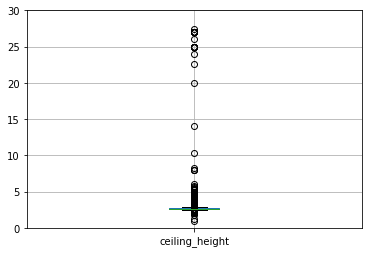

In [102]:
df.boxplot('ceiling_height')
plt.ylim(0, 30)
#plt.xlim(0, 200) 

Будем считать, что высота больше 8 м. - аномалия.

In [103]:
#Найдем аномальные значения высоты потолка
arr = []
for i in range(0, len(df['ceiling_height'].unique())):
    if df['ceiling_height'].unique()[i] > 8:
        arr.append(df['ceiling_height'].unique()[i])
print(arr)

[25.0, 32.0, 27.0, 24.0, 26.0, 8.3, 14.0, 20.0, 22.6, 27.5, 10.3, 100.0]


Значения 25.0, 32.0, 27.0, 24.0, 26.0, 14.0, 20.0, 22.6, 27.5 привдем к дробному виду, например 25 преобразуем к виду 2.5

In [105]:
df.loc[(df['ceiling_height'] >= 20)&(df['ceiling_height'] <= 40), 'ceiling_height'] = df['ceiling_height']/10

In [106]:
#Посмотрим строки со значением 8.3
df[df['ceiling_height'] == 8.3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16,19.3,14,False,...,8.3,1,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0


Так как такое значение встречается редко, удалим его.

In [107]:
df = df[df['ceiling_height'] != 8.3]

In [108]:
#Посмотрим строки со значением 10.3
df[df['ceiling_height'] == 10.3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16,15.5,15,False,...,9.0,0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0


Так как такое значение встречается редко, удалим его.

In [109]:
df = df[df['ceiling_height'] != 10.3]

In [110]:
#Посмотрим строки со значением 100.0
df[df['ceiling_height'] == 100.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25,1,100.0,5,14.0,5,True,...,11.0,5,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


In [111]:
df[df['ceiling_height'] != 100.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.64,11,18.60,1,False,...,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.60,5,34.30,4,False,...,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,95.40,9,False,...,31.80,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.30,3,False,...,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.00,4,False,...,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11,2,2.60,3,29.70,1,False,...,11.34,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,46.05,12,False,...,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Так как такое значение встречается редко, удалим его.

Обработаем аномалии в других столбцах

(0.0, 763000000.0)

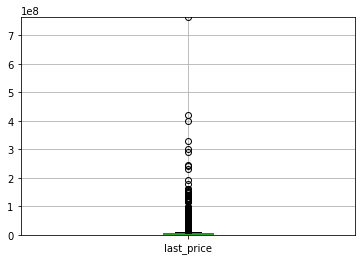

In [112]:
df.boxplot('last_price')
plt.ylim(0, 763000000.0)
#plt.xlim(0, 200) 

In [113]:
df.query('last_price>300000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.0,5,False,...,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
12971,19,763000000.0,400.0,2017-09-30,7,3.38,10,250.0,10,False,...,80.0,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
14706,15,401300000.0,401.0,2016-02-20,5,3.10,9,204.0,9,False,...,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.7,25,False,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Видим, что у нас всего 4 квартиры стоимостью более 300 млн., но мы не будем их удать, т.к. действительно на сайтах существуют квартиры с такой стоимостью и планировкой.

<AxesSubplot:>

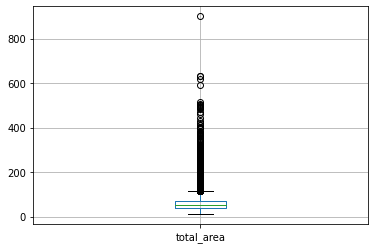

In [114]:
df.boxplot('total_area')

In [115]:
df.query('total_area>800')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Выброс на графике тоже соответсвует дорогой квартире.

<AxesSubplot:>

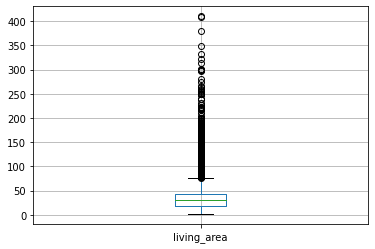

In [116]:
df.boxplot('living_area')

<AxesSubplot:>

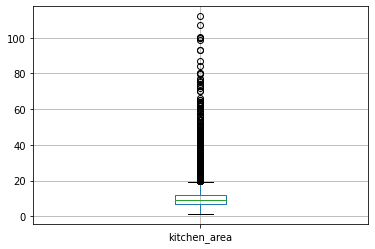

In [117]:
df.boxplot('kitchen_area')

Промежуточные выводы: столбцы ceiling_height, floors_total, living_area, kitchen_area заполнили медианным значением. Пропуски в is_apartment заполнили значением False. Пропуски в столбцах balcony, days_exposition заполнили нулями. Пропуски в столбцах с картографическими данными оставили без изменений. 
Преобразовали first_day_exposition в тип с дата. Столбецы floors_total, balcony, days_exposition преобразовали в целый тип, а is_apartment в булевый. 
Обработали неявные дубликаты в locality_name. В ceiling_height убрали аномалии.

Промежуточные выводы: Столбец floors_total заполнили медианным значением. Для столбцов living_area, kitchen_area нашли их средние доли в зависимости от общей площади. В колонке ceiling_height искали высоту в зависимости от числа комнат. Пропуски в is_apartment заполнили значением False. Пропуски в столбце balcony заполнили нулями. Пропуски в столбцах с картографическими данными оставили без изменений. 
Преобразовали first_day_exposition в тип с дата. Столбецы floors_total, balcony, days_exposition преобразовали в целый тип, а is_apartment в булевый.
Не было обноруженно явных дубликатов. Обработали неявные дубликаты в locality_name. В ceiling_height убрали аномалии, в других столбцах анамалии не оьнаруженны.

### Добавим в таблицу новые столбцы

In [118]:
#Добавим столбец с ценой за один кв. м.
df['price_of_one_square_meter'] = df['last_price'] / df['total_area']

In [119]:
#День недели публикации.
df['day_of_the_publication_week'] = df['first_day_exposition'].dt.weekday

In [120]:
#Месяц публикации объявления
df['month_of_publication'] = df['first_day_exposition'].dt.month

In [121]:
#Год публикации объявления
df['year_of_publication'] = df['first_day_exposition'].dt.year

In [122]:
#тип этажа квартиры
def determine_floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'
df['floor_type'] = df.apply(determine_floor_type, axis=1)

In [123]:
df['cityCenters_nearest_square_meter'] = df.loc[~df['cityCenters_nearest'].isna(), 'cityCenters_nearest'] / 1000
df['cityCenters_nearest_square_meter'] = df.loc[~df['cityCenters_nearest_square_meter'].isna(), 'cityCenters_nearest_square_meter'].astype(int)

Промежуточные выводы: добавили столбцы: цена одного квадратного метра, день недели публикации объявления, месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние до центра города в километрах.

### Проведите исследовательский анализ данных

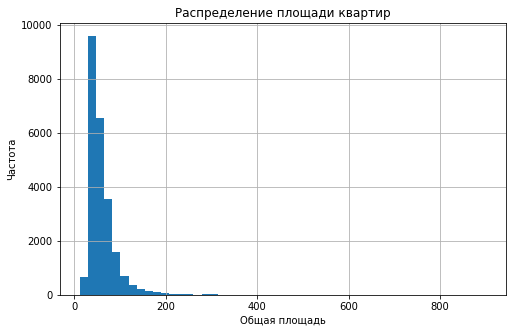

In [125]:
import matplotlib.pyplot as plt

df.hist('total_area', figsize=(8,5), bins=50)
plt.title('Распределение площади квартир')
plt.xlabel('Общая площадь')
plt.ylabel('Частота')
plt.show()

У подавляющего числа квартир площадь находиться на интервале (0, 100].

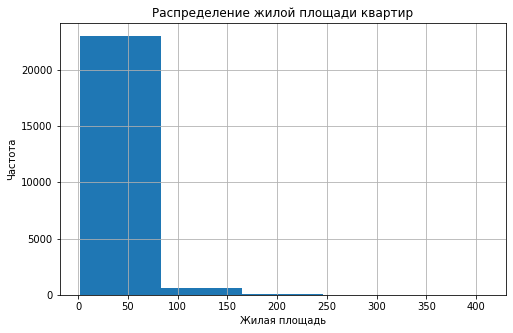

In [126]:
#Построим гстограму для жилой площади
df.hist('living_area', figsize=(8,5), bins=5)
plt.title('Распределение жилой площади квартир')
plt.xlabel('Жилая площадь')
plt.ylabel('Частота')
plt.show()

У подавляющего числа квартир жилая площадь находиться на интервале (0, 80].

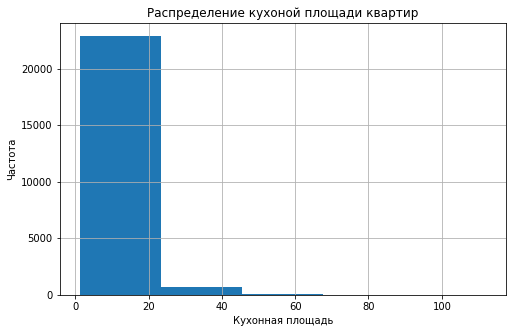

In [127]:
#Построим гстограму для площади кухни
df.hist('kitchen_area', figsize=(8,5), bins=5)
plt.title('Распределение кухоной площади квартир')
plt.xlabel('Кухонная площадь')
plt.ylabel('Частота')
plt.show()

У подавляющего числа кухонная площадь находиться на интервале (0, 22].

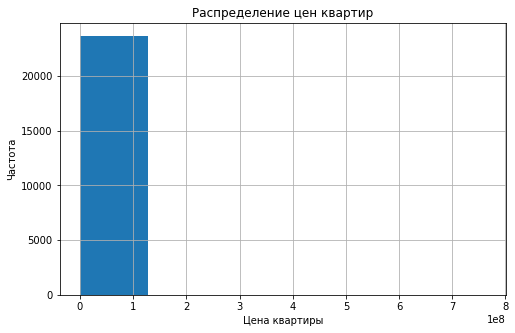

In [128]:
#Построим гстограму для цены объекта
df.hist('last_price', figsize=(8,5), bins=6)
plt.title('Распределение цен квартир')
plt.xlabel('Цена квартиры')
plt.ylabel('Частота')
plt.show()

По данной гистограме сложно судить о поведении цен.

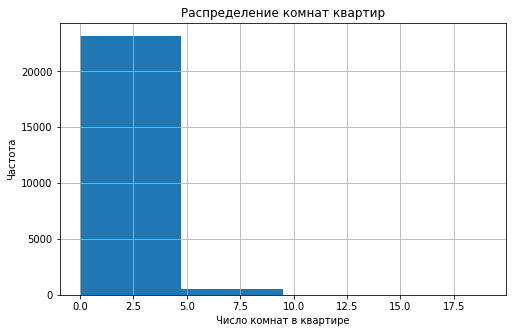

In [129]:
#Построим гстограму для количества комнат
df.hist('rooms', figsize=(8,5), bins=4)
plt.title('Распределение комнат квартир')
plt.xlabel('Число комнат в квартире')
plt.ylabel('Частота')
plt.show()

Чаще всего встречаются квартиры с числом комнат от 1 до 4.

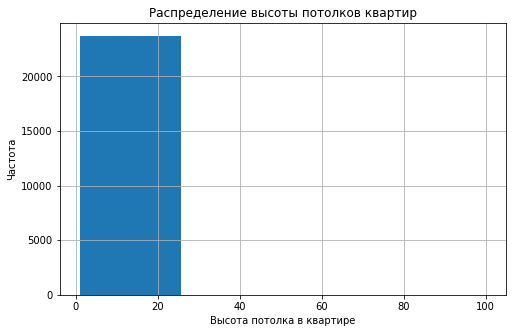

In [130]:
#Построим гстограму для высоты потолков
df.hist('ceiling_height', figsize=(8,5), bins=4)
plt.title('Распределение высоты потолков квартир')
plt.xlabel('Высота потолка в квартире')
plt.ylabel('Частота')
plt.show()

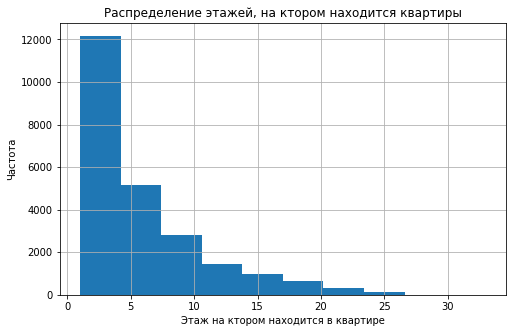

In [131]:
#Построим гстограму для этажей квартиры
df.hist('floor', figsize=(8,5), bins=10)
plt.title('Распределение этажей, на ктором находится квартиры')
plt.xlabel('Этаж на ктором находится в квартире')
plt.ylabel('Частота')
plt.show()

Чаще люди живу на первых пяти этажах, за ними по полярности идут этажи с 6 до 20 по убыванию.

In [132]:
#Построим гстограму для типов этажей квартиры
df['floor_type'].value_counts()

другой       17439
последний     3341
первый        2917
Name: floor_type, dtype: int64

В данной выборке, примерно 26% поцетов квартир размещены на первом, либо на последнем этаже, причем для данных групп их число, почти одинаково. Остальные квартиры пренадлежат группе другой.

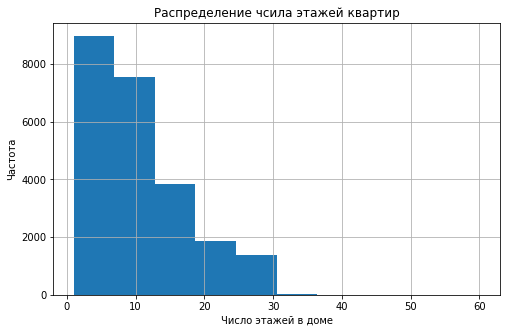

In [133]:
#Построим гстограму для общего количества этажей в доме
df.hist('floors_total', figsize=(8,5), bins=10)
plt.title('Распределение чсила этажей квартир')
plt.xlabel('Число этажей в доме')
plt.ylabel('Частота')
plt.show()

Чаще встречаются здания с числом этажей в диапозоне (0, 12), здания выше встречаются реже.

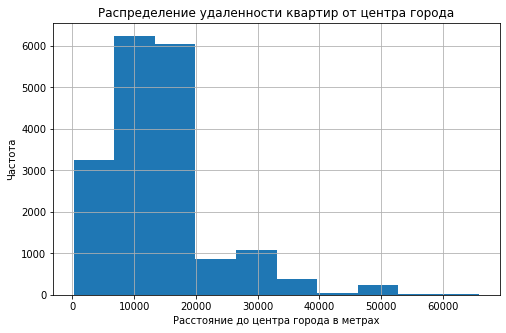

In [134]:
#Построим гстограму для расстояния до центра города в метрах
df.hist('cityCenters_nearest', figsize=(8,5), bins=10)
plt.title('Распределение удаленности квартир от центра города')
plt.xlabel('Расстояние до центра города в метрах')
plt.ylabel('Частота')
plt.show()

Чаще квариры расположены не дальше 2 км от центра.

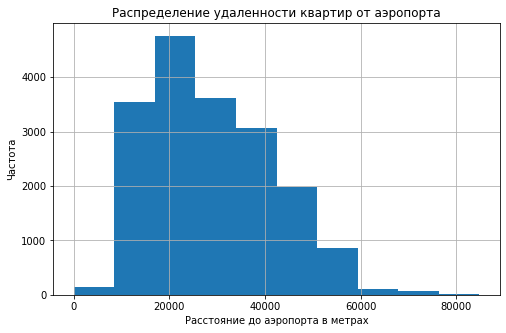

In [135]:
#Построим гстограму для расстояния до ближайшего аэропорта
df.hist('airports_nearest', figsize=(8,5), bins=10)
plt.title('Распределение удаленности квартир от аэропорта')
plt.xlabel('Расстояние до аэропорта в метрах')
plt.ylabel('Частота')
plt.show()

Чаще аэрапорты расположены в диапозоне от 2 км до 4 км.

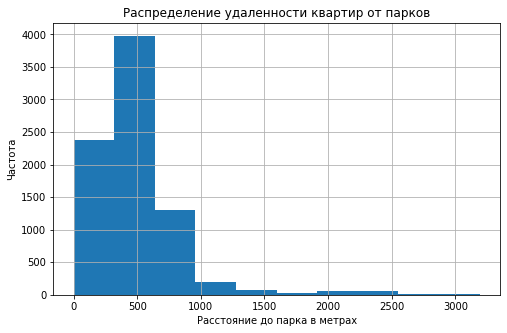

In [136]:
#Построим гстограму для расстояния до ближайшего парка
df.hist('parks_nearest', figsize=(8,5), bins=10)
plt.title('Распределение удаленности квартир от парков')
plt.xlabel('Расстояние до парка в метрах')
plt.ylabel('Частота')
plt.show()

Чаще парки расположены в пределе 1 км.

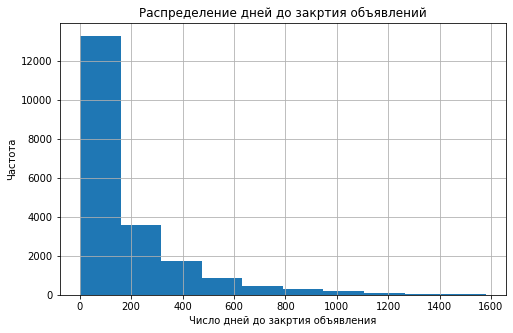

In [137]:
#Построим гстограму для дней публикации объявления
df.hist('days_exposition', figsize=(8,5), bins=10)
plt.title('Распределение дней до закртия объявлений')
plt.xlabel('Число дней до закртия объявления')
plt.ylabel('Частота')
plt.show()

Чаще всего объявления остаются активными в пределах 180 дней

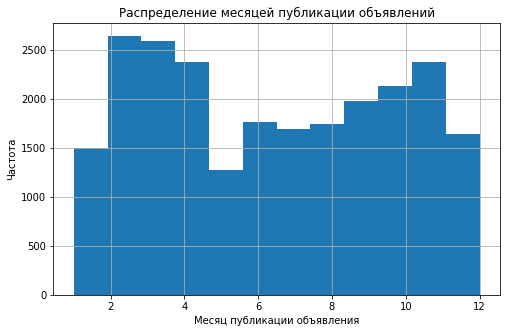

In [138]:
#Построим гстограму для месяцев публикации объявления
df.hist('month_of_publication', figsize=(8,5), bins=12)
plt.title('Распределение месяцей публикации объявлений')
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Частота')
plt.show()

Чаще объявления размещаются зимой, далее весной, осенью и летон примерно одинаковый период активности.

Изучем как быстро продавались квартиры.

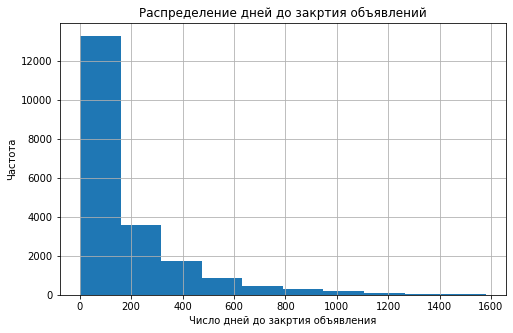

In [139]:
df.hist('days_exposition', figsize=(8,5), bins=10)
plt.title('Распределение дней до закртия объявлений')
plt.xlabel('Число дней до закртия объявления')
plt.ylabel('Частота')
plt.show()

<div class="alert alert-warning"; style="border-left: 7px solid gold">
<font size='4'><b>💡 Комментарий ревьюера</b></font>

Совет: в гистограммах удобно пользоваться параметром bins – он позволяет разбить данные на большее число корзин и добавить детализации в графики
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b>Я понимаю, что с bins можо менять масштаб, но я не могу понять, зачем это нужно делать в данном случае? Какую информацию я смогу увидеть лучше, если масштаб поменяю?</div>

<div class="alert alert-success"; style="border-left: 7px solid green">
<font size='4'><b>👍 Комментарий ревьюера 2</b></font>

Прости, этот комментарий был не к этому конкретному графику, а вообще к разделу. В этом графике автоматическая разбивка вполне удобна
</div>

In [140]:
df['days_exposition'].median()

95.0

In [141]:
df['days_exposition'].mean()

180.89895691167868

Если посмотреть на гистограму продажа в пределах 180 дней. В среднем это происходит за 157 дней. Быстрыми можно назвать продажи, которые осуществляются меньше чем за 74 дня, а долгими, которые продавались дольше 2 лет.

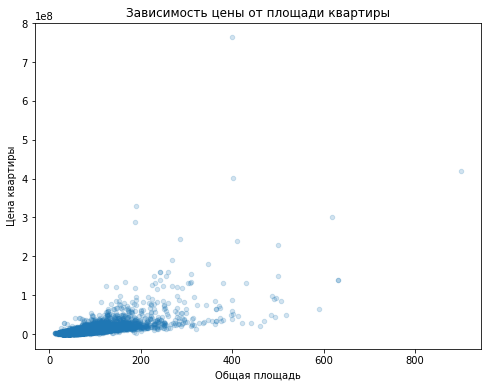

Коэффициент корреляции: 0.6536768825926689


In [142]:
# код ревьюера
df.plot(x='total_area', y='last_price', 
             figsize=(8,6),
             kind='scatter', alpha=0.2)
plt.title('Зависимость цены от площади квартиры')
plt.ylabel('Цена квартиры')
plt.xlabel('Общая площадь')
plt.show()

print('Коэффициент корреляции:', df['total_area'].corr(df['last_price']))

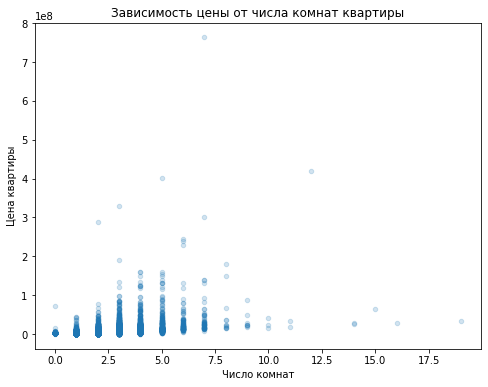

Коэффициент корреляции: 0.36334990612989354


In [143]:
df.plot(x='rooms', y='last_price', 
             figsize=(8,6),
             kind='scatter', alpha=0.2)
plt.title('Зависимость цены от числа комнат квартиры')
plt.ylabel('Цена квартиры')
plt.xlabel('Число комнат')
plt.show()

print('Коэффициент корреляции:', df['rooms'].corr(df['last_price']))

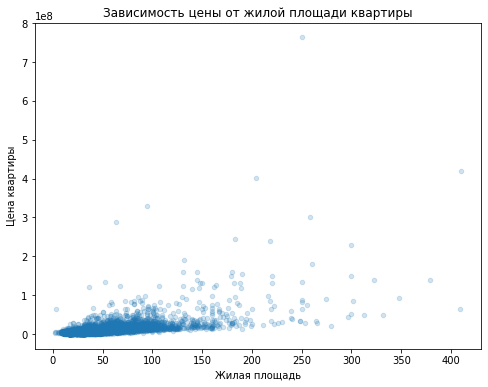

Коэффициент корреляции: 0.5861315200949767


In [144]:
df.plot(x='living_area', y='last_price', 
             figsize=(8,6),
             kind='scatter', alpha=0.2)
plt.title('Зависимость цены от жилой площади квартиры')
plt.ylabel('Цена квартиры')
plt.xlabel('Жилая площадь')
plt.show()

print('Коэффициент корреляции:', df['living_area'].corr(df['last_price']))

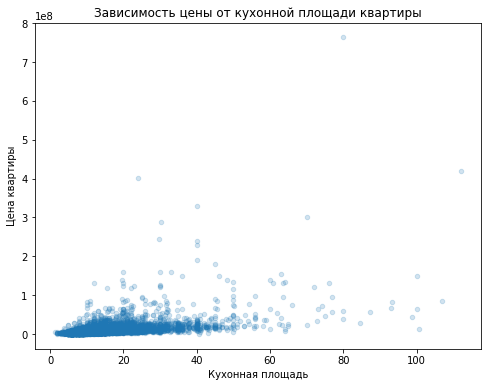

Коэффициент корреляции: 0.5182279642115851


In [145]:
df.plot(x='kitchen_area', y='last_price', 
             figsize=(8,6),
             kind='scatter', alpha=0.2)
plt.title('Зависимость цены от кухонной площади квартиры')
plt.ylabel('Цена квартиры')
plt.xlabel('Кухонная площадь')
plt.show()

print('Коэффициент корреляции:', df['kitchen_area'].corr(df['last_price']))

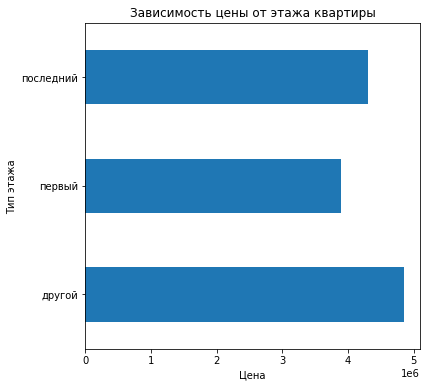

In [146]:
df.pivot_table(index='floor_type', values='last_price', aggfunc='median'
              ).plot(kind='barh', 
                     figsize=(6,6),
                    legend=False)
plt.title('Зависимость цены от этажа квартиры')
plt.xlabel('Цена')
plt.ylabel('Тип этажа')
plt.show()

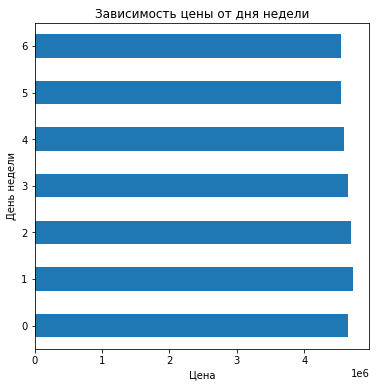

In [147]:
df.pivot_table(index='day_of_the_publication_week', values='last_price', aggfunc='median'
              ).plot(kind='barh', 
                     figsize=(6,6),
                    legend=False)
plt.title('Зависимость цены от дня недели')
plt.xlabel('Цена')
plt.ylabel('День недели')
plt.show()

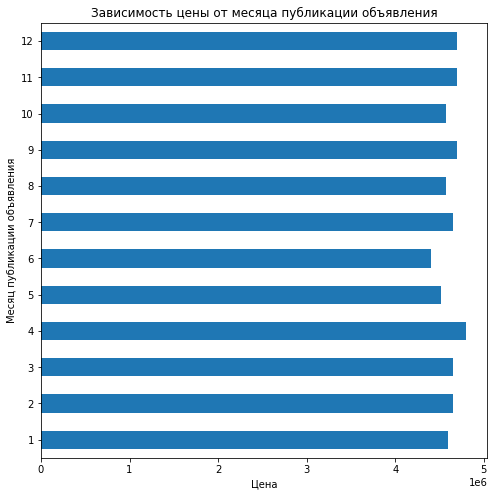

In [148]:
df.pivot_table(index='month_of_publication', values='last_price', aggfunc='median'
              ).plot(kind='barh', 
                     figsize=(8,8),
                    legend=False)
plt.title('Зависимость цены от месяца публикации объявления')
plt.xlabel('Цена')
plt.ylabel('Месяц публикации объявления')
plt.show()

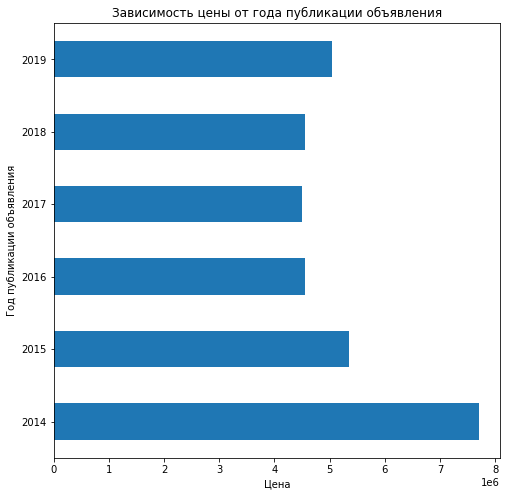

In [149]:
df.pivot_table(index='year_of_publication', values='last_price', aggfunc='median'
              ).plot(kind='barh', 
                     figsize=(8,8),
                    legend=False)
plt.title('Зависимость цены от года публикации объявления')
plt.xlabel('Цена')
plt.ylabel('Год публикации объявления')
plt.show()

Видим, что цена квартиры в основном зависит от её общей площади, жилая и кухонные площади коррелируют с ценой квартиры почти одинаково, от числа комнат цена зависит меньше всего.
Видим, что цена квартиры почти не зависит от дня недели и месяца публикации. Дороже всего квартиры стоилы в 2014 году, дальше цена упала и оставалась на одном уровне для данной выборки.

In [150]:
#Посмотрим 10 самых популярных мест
print(df['locality_name'].value_counts().head(10))

Санкт-Петербург      15719
поселок Мурино         590
Кудрово                472
поселок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                307
Выборг                 237
Name: locality_name, dtype: int64


In [152]:
#Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
df_popluar = df.pivot_table(index='locality_name', values='price_of_one_square_meter', aggfunc=['count', 'median'])
df_popluar.columns = ['count', 'mean']
df_popluar.sort_values(by='count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15719,104761.904762
поселок Мурино,590,86175.643522
Кудрово,472,95675.473579
поселок Шушары,440,76876.172608
Всеволожск,398,65789.473684
Пушкин,369,100000.000000
Колпино,338,74723.748474
поселок Парголово,327,91642.857143
Гатчина,307,67796.610169


Видим, что самая дорогая недвижимость находиться в Санкт-Петербурге, Пушкине, Кудрово, поселоке Парголово, поселоке Мурино. В остальных местах стоимость примерно равна.

In [153]:
#Вычислим среднюю цену каждого километра в Санкт-Петербурге
df.loc[(df['locality_name'] == 'Санкт-Петербург') & (~df['price_of_one_square_meter'].isna()), 'price_of_one_square_meter'].mean()

114848.14135219523

In [154]:
print(df['last_price'].corr(df['cityCenters_nearest_square_meter']))

-0.2068266919291274


Text(0, 0.5, 'Цена квартиры')

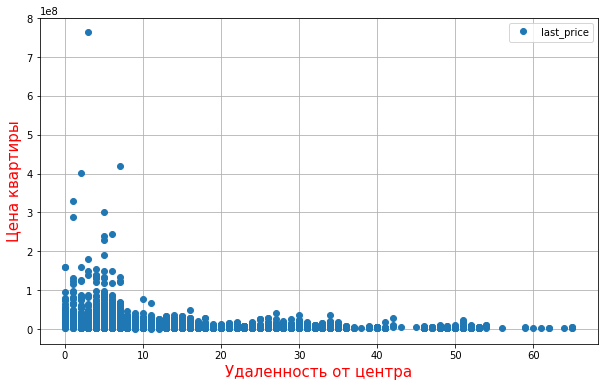

In [155]:
# Построим график зависимости стоимости цены квартиры от расположения её до центра
ax = df.plot(x='cityCenters_nearest_square_meter', y='last_price', style='o', grid=True, figsize=(10, 6))

ax.set_xlabel('Удаленность от центра',
              fontsize = 15,
              color = 'red'
             )

ax.set_ylabel('Цена квартиры',
              fontsize = 15,
              color = 'red'
             )

Из-за того что коэффициент корреляции отрицательный следует, что чем больше цена квартиры тем она ближе к центру. Из графика также видим, что чем ближе квартира к центру тем она дороже.

Промежуточные выводы: У подавляющего числа квартир площадь находиться на интервале (0, 100], жилая площадь находиться на интервале (0, 80],площадь находиться на интервале (0, 22], квартиры с числом комнат от 1 до 4.
Чаще люди живу на первых пяти этажах, за ними по полярности идут этажи с 6 до 20 по убыванию.
В данной выборке, примерно 26% поцетов квартир размещены на первом, либо на последнем этаже, причем для данных групп их число, почти одинаково. Остальные квартиры пренадлежат группе другой.
Чаще встречаются здания с числом этажей в диапозоне (0, 12), здания выше встречаются реже.
Чаще квариры расположены не дальше 2 км от центра, аэрапорты расположены в диапозоне от 2 км до 4 км, парки расположены в пределе 1 км, объявления остаются активными в пределах 180 дней.
Чаще объявления размещаются зимой, далее весной, осенью и летон примерно одинаковый период активности.
Продажа чаще всего осуществляется в пределах 180 дней. В среднем это происходит за 157 дней. Быстрыми можно назвать продажи, которые осуществляются меньше чем за 74 дня, а долгими, которые продавались дольше 2 лет.
Цена квартиры в основном зависит от её общей площади, жилая и кухонные площади коррелируют с ценой квартиры почти одинаково, от числа комнат цена зависит меньше всего.
Видим, что цена квартиры почти не зависит от дня недели и месяца публикации. Дороже всего квартиры стоилы в 2014 году, дальше цена упала и оставалась на одном уровне для данной выборки.
Самая дорогая недвижимость находиться в Санкт-Петербурге, Пушкине, Кудрово, поселоке Парголово, поселоке Мурино. В остальных местах стоимость примерно равна.
Среднюю цена каждого километра в Санкт-Петербурге = 114848.14135219523
Чем больше цена квартиры тем она ближе к центру.


### Общий вывод

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.
О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка.

Имеем датафрейм с 23698 строками и 22 колонками, во множестве столбцов имеем пропущенные значения, которые нужно постараться заполнить.

Столбцы ceiling_height, floors_total, living_area, kitchen_area заполнили медианным значением. Пропуски в is_apartment заполнили значением False. Пропуски в столбцах balcony, days_exposition заполнили нулями. Пропуски в столбцах с картографическими данными оставили без изменений. 
Преобразовали first_day_exposition в тип с дата. Столбецы floors_total, balcony, days_exposition преобразовали в целый тип, а is_apartment в булевый. 
Обработали неявные дубликаты в locality_name. В ceiling_height убрали аномалии.

Добавили столбцы: цена одного квадратного метра, день недели публикации объявления, месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние до центра города в километрах.

У подавляющего числа квартир площадь находиться на интервале (0, 100], жилая площадь находиться на интервале (0, 80],площадь находиться на интервале (0, 22], квартиры с числом комнат от 1 до 4.
Чаще люди живу на первых пяти этажах, за ними по полярности идут этажи с 6 до 20 по убыванию.
В данной выборке, примерно 26% поцетов квартир размещены на первом, либо на последнем этаже, причем для данных групп их число, почти одинаково. Остальные квартиры пренадлежат группе другой.
Чаще встречаются здания с числом этажей в диапозоне (0, 12), здания выше встречаются реже.
Чаще квариры расположены не дальше 2 км от центра, аэрапорты расположены в диапозоне от 2 км до 4 км, парки расположены в пределе 1 км, объявления остаются активными в пределах 180 дней.
Чаще объявления размещаются зимой, далее весной, осенью и летон примерно одинаковый период активности.
Продажа чаще всего осуществляется в пределах 180 дней. В среднем это происходит за 157 дней. Быстрыми можно назвать продажи, которые осуществляются меньше чем за 74 дня, а долгими, которые продавались дольше 2 лет.
Цена квартиры в основном зависит от её общей площади, жилая и кухонные площади коррелируют с ценой квартиры почти одинаково, от числа комнат цена зависит меньше всего. Цена квартиры почти не зависит от дня недели, месяца или года публикации.
Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений = 108920.3840403652
Среднюю цена каждого километра в Санкт-Петербурге = 114848.14135219523
Чем больше цена квартиры тем она ближе к центру.